<img src="https://www2.gmu.edu/sites/all/modules/features/feature_core_theme/templates/resources/images/mason-logo.png " alt="GMU Logo" title="George Mason University" />
<hr style ="color:#99CC99">
    
<h2 style="font-family:Helvetica; color:#006633;">Programming Assignment # 3</h2>
<h3 style="font-family:Helvetica; color:#006633;"> Named Entity Recognition (NER) with Recurrent Neural Network (RNN)</h3>

<p style="font-family:Helvetica; font-size:1.5em;"> 
Authors: Team 1 - Shinoj Jerald Bounaventure Kumar Jeronmary, Yitong Li, Anh Nguyen and Nina Nnamani<br>
Course Professor: Dr. Lindi Liao <br>
Course Name: Natural Language Processing <br>
Course Name and Section#: AIT 
726-001<br>
University Name: George Mason University<br>
Date: October 29, 2020    <br>
</p>    
<hr style ="color:#99CC99" width="75%">
<p style="font-family:Helvetica; font-size:1.4em;"> 
Description: In this assignment, we will build 7 neural networks (vanilla RNN, bidirectional RNN, LSTM and bidirectional LSTM, GRU and bidirectional GRU and a modified version of the best RNN out of the previous 6) for Named Entity Recognition (NER) on CONLL 2003 dataset. The goal is to classify words into 10 different classes: , O, B-ORG, B-PER, B-LOC, B-MISC, IORG, I-PER, I-LOC, I-MISC. We are identifying whether words are part of a phrase referring to an organization, person, location, or miscellaneous. B indicates that word is at the beginning of the phrase, I indicates that the word is inside the phrase but not the first word, O indicates it is outside the phrase (does not belong to it).
 <br>
    
<p style="font-family:Helvetica; font-size:1.4em;"> 
Instructions: This program is presented as a jupyter notebook and requires all packages in the import packages section to be installed prior to running the code to avoid errors. All the input raw data and the pre-train word embeddings word2vec are located in the same directory. The outline of the program closely resembles the order of the implemented features below. An html file of program of all outputs are included in this submission. The following overarching features are implemented:<br>

<p style="font-family:Helvetica; font-size:1.2em;"> 
1) Import packages necessary for the assignment (keras, gensim, numpy, sklearn, matplotlib)<br>
2) Create functions for data preprocessing: paddings in sentences and assigning <pad> tag to them; normalize words to lowercase except all-cap words; reading input files and separate sentences from tags based on the first and last column in the data; vectorize words, lines and tags with word2vec (words that are not sentence paddings or out-of-vocab. OOV are assigned a value of 1, padding 0s is enumerated as 0); convert class sequences into word categories <br>
3) Define functions to build the models: Create vanilla RNN from Keras Sequential package; add input layer equals to maximum length of text; use simple RNN with 256 dimensions with softmax activation function and Adam optimizer with learning rate 0.0001; functions that create LSTM and GRU models with the similar settings, Bidirectional RNN, Bidirectiona LSTM and Bidirectional GRU using Keras <br>
4) Define function that gets metrics and test evaluation and predictions from the same package that created the models. <br>
5) Testing the models (6 in total)<br> 
6) Assess the models and choose the architecture with the highest accuracy to modify as the 7th model. 

<br> 
           
<p style="font-family:Helvetica; font-size:1.4em;"> 


In [1]:
#using pad_sequences from pytorch to pad sentences to equal length
#from torch.nn.utils.rnn import pad_sequence
#if using keras, enable the line below
from keras.preprocessing.sequence import pad_sequences
from gensim import models
from numpy import zeros
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation,TimeDistributed,InputLayer,Bidirectional,LSTM,GRU, Input
from keras import optimizers
#use Adam optimizer with learning rate 0.0001
from keras.optimizers import Adam
from keras.layers import Embedding
from keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn import preprocessing
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
tag_list_prime=['<pad>','O','B-ORG', 'B-PER','B-LOC', 'B-MISC', 'I-LOC','I-PER','I-ORG', 'I-MISC']

def pad_tags(tags_list,max_len):
    #Pad the tags
    #assign <pad> as tags for the 0s in padded sentences
    for i in range(0,len(tags_list)):
        tags_list[i] += ['<pad>']  * (max_len - len(tags_list[i]))

    return tags_list
     

#enable this function if using Keras. otherwise, use pad_sequence from pytorch 
def pad_seq(line_list,max_len):
    #Pad each line to match the max sentence length
    #enable line below if using keras
    sent_list = pad_sequences(line_list, maxlen=max_len,padding='post')
    
    return sent_list

In [3]:
def normalize_case(s):    
    #Paramaeter: Word to be normalized
    #Converts words with capitalized first letters in to lower case. is s.isupper() then returns s
    if(not s.isupper()):
        return s.lower()
    else:
        return s

Pre-processing: Read the complete data. First column has the words to be classified, and last column shows the
gold standard tag for each word. Lower case capitalized words (i.e., starts with a capital letter) but not all
capital words (e.g., USA). Do not remove stopwords. Data is already separated by sentence and tokenized, so
do not use different tools to tokenize for this task. Separate data by sentence. Once you know the maximum
sentence length in the data, append 0s at the end of shorter sentences to make them match this max length.
Set the tag for the 0s to <pad>. 

In [4]:
vocab=set([])
def openandread(path):
    #load the file and create list for sentences and tags
    tag_list=[]
    with open(path) as f:
        sent=[]
        tag=[]
        line_list=[]
        for line in f:
            content=line.split()

            if (line in ['\n', '\r\n']):
                if(len(sent)>0):
                    line_list.append(sent)
                    tag_list.append(tag)
                    sent = []
                    tag = []
            else:
                if content[0] != '-DOCSTART-':
                    token = normalize_case(content[0])
                    sent.append(token)
                    vocab.add(token)
                    tag.append(content[3])


    #return 2 lists
    return line_list,tag_list

In [5]:
# embedding 
def vectorize_line(line_list,words):
    #Convert word to index
    word2index = {w: i for i, w in enumerate(list(words))}
    word2index['-PAD-'] = 0  # The special value used for padding
    word2index['-OOV-'] = 1  # The special value used for OOVs
    train_list=[]
    for s in line_list:
        s_int = []
        for w in s:
            try:
                s_int.append(word2index[w.lower()])
            except KeyError:
                s_int.append(word2index['-OOV-'])
        train_list.append(s_int)
    #embeddings_index = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    #line_vec = [[w[word] for word in line if word in w] for line in line_list]
    return train_list,word2index

Embeddings: Use pretrained word embeddings.These are word2vec
embeddings trained on the google news dataset. You will find 300 dimensional embedding vectors for 3 million words and phrases. Use them as your input vector representations

In [6]:
def vectorize_tag(tags,tag_list):
    #Convert tags to index
    tag2index = {t: i for i, t in enumerate(list(tags))}
    test_tags_y=[]
    for s in tag_list:
        test_tags_y.append([tag2index[t] for t in s])
    return test_tags_y

In [7]:
def embed(word2index):
    #Create embedding matrix using word2vec
    filepath='./GoogleNews-vectors-negative300.bin'
    embeddings_index = models.KeyedVectors.load_word2vec_format(filepath, binary=True)
    emb_matrix = np.zeros((len(word2index)+2, 300))
    embeddings_index['-DOCSTART-']=np.zeros(300)
    for word, i in word2index.items():
        if(word in embeddings_index):
            embedding_vector = embeddings_index[word]
        else:
            embedding_vector =np.zeros(300)
        if embedding_vector is not None:
            emb_matrix[i] = embedding_vector
    return emb_matrix

Training: Build an RNN. Start with a vanilla RNN, with one layer of 256 hidden units, and a fully connected
output layer using softmax as activation function. Use Adam optimizer, and cross-entropy for the loss function
with learning rate 0.0001. Try a bidirectional RNN with the same settings. Train with 2000 mini batches per
epoch. You may see convergence around 5000 epochs. You can change the RNN unit to LSTM or GRUs in both
the unidirectional and bidirectional architectures, and experiment with different learning rates and batch
sizes. Complete your system architecture, as well as hyperparameter and parameter tuning using training and
validation data. Finally, for the best architecture among the 6 (pick one!) above (RNN, bi-RNN, LSTM, bi-LSTM,
GRU, bi-GRU), make the necessary modifications to update the embeddings along with the rest of the network.
This is your 7th and final system. Save your trained systems (i.e., models) using libraries such as
callbacks.ModelCheckpoint(...) or model.save_weights(..).

In [8]:
def to_categorical(sequences, categories):
    #Create label encoding of y variable(tags)
    class_sequences = []
    for s in sequences:
        class_cats = []
        for item in s:
            x=np.zeros(categories)
            x[item] = 1.0
            class_cats.append(x)
        class_sequences.append(class_cats)
    return np.array(class_sequences)

In [9]:
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1) #get max prob from true labels 
        y_pred_class = K.argmax(y_pred, axis=-1) #get max prob from softmax 

        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy

    return ignore_accuracy


In [10]:
def vanilla_rnn(max_len,emb_matrix):
    #Creates vanilla rnn model
    model = Sequential(name='Vanilla_RNN_model') #Implements the sequence
    model.add(InputLayer(input_shape=(max_len, ))) #Input layer for max length of text
    model.add(Embedding(len(vocab), 128,trainable=True))
    model.add(SimpleRNN(256, return_sequences=True))
    model.add(TimeDistributed(Dense(10)))
    model.add(Activation('softmax')) #for multi-classes
     
    model.compile(loss='categorical_crossentropy', #loss function
                  optimizer=Adam(0.0001),#learning rate with Adam optimizer
                  metrics=['accuracy',ignore_class_accuracy(0)])
    print(model.summary())
    return model


In [11]:
def lstm_model(max_len,emb_matrix):
    #Creates lstm model
    model = Sequential(name='LSTM_model') #Implements the sequence
    model.add(InputLayer(input_shape=(max_len, )))#Input layer for max length of text
    model.add(Embedding(len(vocab), 300))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(10)))
    model.add(Activation('softmax'))#for multi-classes
    model.compile(loss='categorical_crossentropy', #loss function
                  optimizer=Adam(0.0001),#learning rate with Adam optimizer
                  metrics=['accuracy',ignore_class_accuracy(0)]) 
    print(model.summary())
    return model

In [12]:
#Here, we are defining GRU model, GRU model is Gated Recurrent Unit which is an recurrent neural network architecture.
#GRU model is similar to LSTM Model. GRU comprises of the reset gate and the update gate instead of the input, output and forget gate of the LSTM
def gru_model(max_len,emb_matrix):
    #Creates gru model
    model = Sequential(name='GRU_model')
    #Adding the neural network input layer
    model.add(InputLayer(input_shape=(max_len, )))
    model.add(Embedding(len(vocab), 128))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(10)))
    #Adding the input layer with softmax activation function
    model.add(Activation('softmax'))
    #Giving categorical crossentropy as loss function and using adam optimizer with accuracy as metrics.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy',ignore_class_accuracy(0)])
    #Printing the model summary
    print(model.summary())
    return model

In [13]:
#Here we are defining Bidirectional RNN,in order to connect two hidden recurrent neural network layers of opposite directions together into the same output
#Bidirectional recurrent neural networks(RNN) are really just putting two independent RNNs together. 
#The input sequence is fed in normal time order for one network, and in reverse time order for another. 
def Bidirectional_rnn(max_len,emb_matrix):
    #Creates bidirectional rnn model
    model = Sequential(name='Bidirectional_RNN_model')
    #Adding the neural network input layer
    model.add(InputLayer(input_shape=(max_len, )))
    model.add(Embedding(len(vocab), 128))
    model.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
    #Adding Time Distribution which applies a layer to every temporal slice of an input
    model.add(TimeDistributed(Dense(10)))
    #Adding the input layer with softmax activation function
    model.add(Activation('softmax'))
    #We are giving categorical crossentropy as loss function and using adam optimizer with accuracy as metrics.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy',ignore_class_accuracy(0)])
    #Printing the model summary.
    print(model.summary())
    return model

In [14]:
#Here, we are defining Bidirectional LSTM which is an extension of traditional LSTM. 
#In order to improve model performance on sequence classification, we are using Bidirectional LSTM. 
#Here, Bidirectional LSTM train two inputs as nlp input and meta input instead of one LSTMs on the input sequence.
def Bidirectional_LSTM(max_len,emb_matrix):
    #Creates bidirectional lstm
    nlp_input = Input(shape=(max_len,), name='nlp_input')
    meta_input = Input(shape=(10,), name='meta_input')
    model = Sequential(name='Bidirectional_LSTM_model')
    #Adding the neural network input layer
    model.add(InputLayer(input_shape=(max_len, )))
    model.add(Embedding(len(vocab), 300))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    #Adding Time Distribution which applies a layer to every temporal slice of an input
    model.add(TimeDistributed(Dense(10))) 
    # Adding the input layer with softmax activation function                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    model.add(Activation('softmax'))
    #We are giving categorical crossentropy as loss function and using adam optimizer with accuracy as metrics
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.001),
                  metrics=['accuracy',ignore_class_accuracy(0)])
    #Printing the model summary.
    print(model.summary())
    return model

In [15]:
#Here, we are defining Bidirectional GRU which is a type of bidirectional recurrent neural networks with only the input and forget gates. 
#It allows for the use of information from both previous time steps and later time steps to make predictions about the current state.
def Bidirectional_GRU(max_len,emb_matrix):
    #Creates bidirectional gru
    model = Sequential(name='Bidirectional_GRU_model')
    #Adding the neural network input layer
    model.add(InputLayer(input_shape=(max_len, )))
    #adding embedding which provides a dense representation of words and their relative meanings
    model.add(Embedding(len(vocab), 300,trainable=True))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    #Adding Time Distribution which applies a layer to every temporal slice of an input
    model.add(TimeDistributed(Dense(10)))
    #Adding the input layer with softmax activation function
    model.add(Activation('softmax'))
    #We are giving categorical crossentropy as loss function and using adam optimizer with accuracy as metrics
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy',ignore_class_accuracy(0)])
    #Printing the model summary.
    print(model.summary())
    return model

In [16]:
#Function to get. text files. and log of models
def packAndStore(x,filename):
    y=[]
    for i in x:
        sub_y=[]
        for j in i:
            sub_y.append(tag_list_prime[np.argmax(j, axis=0)])
        y.append(sub_y)

    result=[]
    for i in range(0,len(line_list_test)):
        for j in range(0,len(line_list_test[i])):
            try:
                y[i][j]
                if(y[i][j]!='<pad>'):
                    result.append(line_list_test[i][j]+" "+tag_list_test[i][j]+" "+y[i][j])
            except IndexError:
                continue

    with open(filename, 'w') as f:
        for item in result:
            f.write("%s\n" % item)

In [17]:
#Function to plot accuracy converging of training vs validation
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

In [18]:
#Function to plot loss converging of training vs validation
def loss_plot(title_, history_fit):
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title(title_)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

Testing: Apply your trained models (7 total) to test data. Save your output and results in a .txt or a .log file.
Results should be in the following format:
Word Gold_Standard Prediction
SOCCER O O
- O O
MEXICO B-LOC B-LOC
GET O O

In [19]:
#reading in train, validation and testing date function
line_list_train=[]
tag_list_train=[]
line_list_train,tag_list_train=openandread(r'./conll2003/train.txt')

line_list_valid=[]
tag_list_valid=[]
line_list_valid,tag_list_valid=openandread(r'./conll2003/valid.txt')

line_list_test=[]
tag_list_test=[]
line_list_test,tag_list_test=openandread(r'./conll2003/test.txt')

In [20]:
#getting embeddings, applying padding and list tags
max_len_train = len(max(line_list_train, key=len))
line_vec_train,word2index=vectorize_line(line_list_train,vocab)
line_vec_train = pad_seq(line_vec_train,max_len_train)

#max_len_valid = len(max(line_list_valid, key=len))
line_vec_valid,word2index=vectorize_line(line_list_valid,vocab)
line_vec_valid = pad_seq(line_vec_valid,max_len_train)
    
#max_len_test = len(max(line_list_train, key=len))
line_vec_test,word2index=vectorize_line(line_list_test,vocab)
line_vec_test = pad_seq(line_vec_test,max_len_train)
    
#embedding matrix
emb_matrix=embed(word2index)

#padding tags   
padded_tag_train = pad_tags(tag_list_train,max_len_train)
tag_vec_train=vectorize_tag(tag_list_prime,padded_tag_train)
    
padded_tag_valid = pad_tags(tag_list_valid,max_len_train)
tag_vec_valid=vectorize_tag(tag_list_prime,padded_tag_valid)
    
padded_tag_test = pad_tags(tag_list_test,max_len_train)
tag_vec_test=vectorize_tag(tag_list_prime,padded_tag_test)

In [21]:
#Implementing label encoding to categorical function
tag_vec_one_hot_train = to_categorical(tag_vec_train, 10)
tag_vec_one_hot_valid = to_categorical(tag_vec_valid,10)
tag_vec_one_hot_test = to_categorical(tag_vec_test,10)

VANILLA RNN MODEL

In [22]:
#Vanilla model
vanilla_RNN_model=vanilla_rnn(max_len_train,emb_matrix)
vanilla_RNN_history=vanilla_RNN_model.fit(line_vec_train, tag_vec_one_hot_train, batch_size=200, epochs = 20,  validation_data=(line_vec_valid, tag_vec_one_hot_valid))

Model: "Vanilla_RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 113, 128)          3641088   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 113, 256)          98560     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 113, 10)           2570      
_________________________________________________________________
activation_1 (Activation)    (None, 113, 10)           0         
Total params: 3,742,218
Trainable params: 3,742,218
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/20
14041/14041 [==============================] - 31s 2ms/step - loss: 0.7124 - accuracy: 0.8280 - ignore_accuracy: 0.2919 - val_loss: 0.3592 - val_accuracy: 0.8781 - val_ignore_accuracy: 0.5707
Epoch 2/20
14041/14041 [==============================] - 31s 2ms/step - loss: 0.2661 - accuracy: 0.9223 - ignore_accuracy: 0.7397 - val_loss: 0.2467 - val_accuracy: 0.9393 - val_ignore_accuracy: 0.7743
Epoch 3/20
14041/14041 [==============================] - 31s 2ms/step - loss: 0.2074 - accuracy: 0.9526 - ignore_accuracy: 0.7851 - val_loss: 0.2100 - val_accuracy: 0.9558 - val_ignore_accuracy: 0.7633
Epoch 4/20
14041/14041 [==============================] - 30s 2ms/step - loss: 0.1785 - accuracy: 0.9657 - ignore_accuracy: 0.7937 - val_loss: 0.1932 - val_accuracy: 0.9640 - val_ignore_accuracy: 0.7886
Epoch 5/20
14041/14041 [==============================] - 30s 2ms/step - loss: 0.1593 - accuracy: 0.9703 - ignore_accuracy: 0.7959 - val_lo

In [23]:
#predict on the test data
x1= vanilla_RNN_model.predict(line_vec_test)

BIDIRECTIONAL RNN MODEL

In [25]:
#Bi RNN model
Bidirectional_RNN_model=Bidirectional_rnn(max_len_train,emb_matrix)
Bidirectional_RNN_history=Bidirectional_RNN_model.fit(line_vec_train, tag_vec_one_hot_train, epochs = 1, batch_size=200,  validation_data=(line_vec_valid, tag_vec_one_hot_valid))

Model: "Bidirectional_RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 113, 128)          3641088   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 113, 512)          197120    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 113, 10)           5130      
_________________________________________________________________
activation_3 (Activation)    (None, 113, 10)           0         
Total params: 3,843,338
Trainable params: 3,843,338
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/1
14041/14041 [==============================] - 68s 5ms/step - loss: 0.4881 - accuracy: 0.8882 - ignore_accuracy: 0.4259 - val_loss: 0.2289 - val_accuracy: 0.9476 - val_ignore_accuracy: 0.7180


In [26]:
#predict on the test data
x2= Bidirectional_RNN_model.predict(line_vec_test)

LSTM MODEL

In [27]:
#LSTM model
LSTM_model=lstm_model(max_len_train,emb_matrix)
LSTM_history=LSTM_model.fit(line_vec_train, tag_vec_one_hot_train, epochs = 1, batch_size=200,  validation_data=(line_vec_valid, tag_vec_one_hot_valid))

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 113, 300)          8533800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 113, 256)          570368    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 113, 10)           2570      
_________________________________________________________________
activation_4 (Activation)    (None, 113, 10)           0         
Total params: 9,106,738
Trainable params: 9,106,738
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/1
14041/14041 [==============================] - 172s 12ms/step - loss: 1.1246 - accuracy: 0.7988 - ignore_accuracy: 0.4517 - val_loss: 0.3988 - val_accuracy: 0.8620 - val_ignore_accuracy: 0.7878


In [28]:
#predict on the test data
x3= LSTM_model.predict(line_vec_test)

BIDIRECTIONAL LSTM MODEL

In [29]:
Bidirectional_LSTM_model=Bidirectional_LSTM(max_len_train,emb_matrix)
Bidirectional_LSTM_history=Bidirectional_LSTM_model.fit(line_vec_train, tag_vec_one_hot_train, epochs = 1, batch_size=150,  validation_data=(line_vec_valid, tag_vec_one_hot_valid))    

Model: "Bidirectional_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 113, 300)          8533800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 113, 512)          1140736   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 113, 10)           5130      
_________________________________________________________________
activation_5 (Activation)    (None, 113, 10)           0         
Total params: 9,679,666
Trainable params: 9,679,666
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/1
14041/14041 [==============================] - 350s 25ms/step - loss: 0.2202 - accuracy: 0.9549 - ignore_accuracy: 0.7447 - val_loss: 0.1021 - val_accuracy: 0.9765 - val_ignore_accuracy: 0.8190


In [32]:
Bidirectional_LSTM_model.predict(line_vec_test)

array([[[2.24286737e-03, 8.09935331e-01, 3.42425071e-02, ...,
         2.80922428e-02, 1.79355871e-02, 5.16015245e-03],
        [2.33478006e-03, 8.10699522e-01, 3.33225206e-02, ...,
         2.78606545e-02, 1.79834571e-02, 5.23856888e-03],
        [6.38049189e-03, 6.33681297e-01, 6.38313070e-02, ...,
         5.16934730e-02, 3.22600007e-02, 9.78476927e-03],
        ...,
        [9.99999523e-01, 3.52215146e-09, 2.24890542e-07, ...,
         2.85260402e-08, 3.04141565e-08, 9.03998032e-09],
        [9.99999166e-01, 4.44235493e-09, 4.11932319e-07, ...,
         5.43689218e-08, 5.71643923e-08, 1.91394207e-08],
        [9.99997854e-01, 6.89383040e-09, 8.10372057e-07, ...,
         1.10422533e-07, 1.14085047e-07, 4.18017301e-08]],

       [[5.60049526e-02, 7.12817371e-01, 4.54552472e-02, ...,
         3.02193165e-02, 2.42018066e-02, 7.49282958e-03],
        [1.37338385e-01, 6.32791996e-01, 4.43051346e-02, ...,
         2.97326948e-02, 2.53623705e-02, 8.22360534e-03],
        [7.00541735e-01, 

In [30]:
#predict on the test data
x4= Bidirectional_LSTM_model.predict(line_vec_test)

GRU MODEL

In [33]:
GRU_model=gru_model(max_len_train,emb_matrix)
GRU_history=GRU_model.fit(line_vec_train, tag_vec_one_hot_train, epochs = 1,  validation_data=(line_vec_valid, tag_vec_one_hot_valid))

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 113, 128)          3641088   
_________________________________________________________________
lstm_4 (LSTM)                (None, 113, 256)          394240    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 113, 10)           2570      
_________________________________________________________________
activation_7 (Activation)    (None, 113, 10)           0         
Total params: 4,037,898
Trainable params: 4,037,898
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/1
14041/14041 [==============================] - 267s 19ms/step - loss: 0.4063 - accuracy: 0.9084 - ignore_accuracy: 0.6779 - val_loss: 0.2078 - val_accuracy: 0.9554 - val_ignore_accuracy: 0.7603


In [34]:
#predict on the test data
x5=GRU_model.predict(line_vec_test)

BIDIRECTIONAL GRU MODEL

In [35]:
Bidirectional_GRU_model=Bidirectional_GRU(max_len_train,emb_matrix)
Bidirectional_GRU_history=Bidirectional_GRU_model.fit(line_vec_train, tag_vec_one_hot_train, epochs = 1,  batch_size=150,validation_data=(line_vec_valid, tag_vec_one_hot_valid))

Model: "Bidirectional_GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 113, 300)          8533800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 113, 512)          855552    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 113, 10)           5130      
_________________________________________________________________
activation_8 (Activation)    (None, 113, 10)           0         
Total params: 9,394,482
Trainable params: 9,394,482
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/1
14041/14041 [==============================] - 444s 32ms/step - loss: 0.9165 - accuracy: 0.8753 - ignore_accuracy: 0.5587 - val_loss: 0.3094 - val_accuracy: 0.9247 - val_ignore_accuracy: 0.8605


In [36]:
#predict on the test data
x6= Bidirectional_GRU_model.predict(line_vec_test)

In [37]:
#Implement function to save txt file and log
packAndStore(x1,'vanilla-rnn.txt')
packAndStore(x2,'bi-rnn.txt')
packAndStore(x3,'lstm.txt')
packAndStore(x4,'bi-lstm.txt')
packAndStore(x5,'gru.txt')
packAndStore(x6,'bi-gru.txt')

## FINAL MODEL
### The Bidirectional LSTM model
Less overfitting compared to other models

In [38]:
Final_model=Bidirectional_LSTM(max_len_train,emb_matrix)
Final_model_Bidirectional_LSTM_history=Final_model.fit(line_vec_train, tag_vec_one_hot_train, epochs = 1, batch_size=150,  validation_data=(line_vec_valid, tag_vec_one_hot_valid))    

Model: "Bidirectional_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 113, 300)          8533800   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 113, 512)          1140736   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 113, 10)           5130      
_________________________________________________________________
activation_9 (Activation)    (None, 113, 10)           0         
Total params: 9,679,666
Trainable params: 9,679,666
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\jayma\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14041 samples, validate on 3250 samples
Epoch 1/1
14041/14041 [==============================] - 303s 22ms/step - loss: 0.2128 - accuracy: 0.9549 - ignore_accuracy: 0.7525 - val_loss: 0.1029 - val_accuracy: 0.9765 - val_ignore_accuracy: 0.8189


In [39]:
x7= Final_model.predict(line_vec_test)


In [40]:
packAndStore(x7,'final_model.txt')

Bonus Point:
- (1 point) Use the statistical significance test to choose the best performing model. Explain the results of
the test.


- (1 point) Does your final algorithm converge? Provide a proof of convergence graphically

Yes, there is convergence.

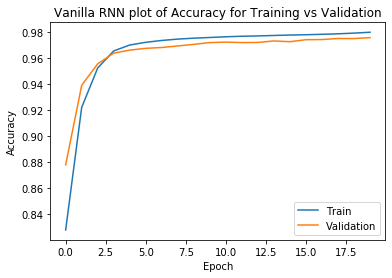

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [41]:
plot1=accuracy_plot("Vanilla RNN plot of Accuracy for Training vs Validation", vanilla_RNN_history)
plot1

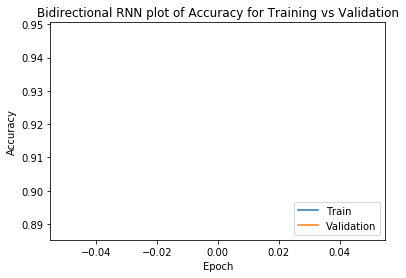

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [42]:
plot2=accuracy_plot("Bidirectional RNN plot of Accuracy for Training vs Validation", Bidirectional_RNN_history)
plot2

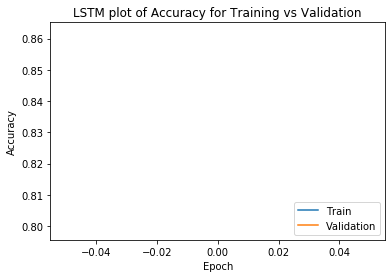

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [43]:
plot3=accuracy_plot("LSTM plot of Accuracy for Training vs Validation", LSTM_history)
plot3

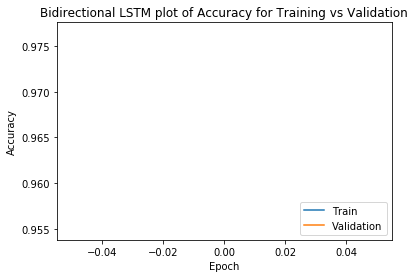

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [44]:
plot4=accuracy_plot("Bidirectional LSTM plot of Accuracy for Training vs Validation", Bidirectional_LSTM_history)
plot4

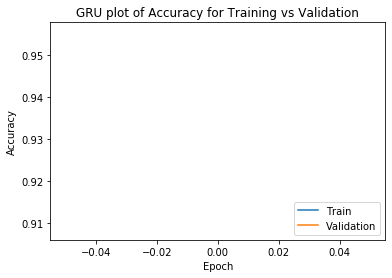

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [45]:
plot5=accuracy_plot("GRU plot of Accuracy for Training vs Validation", GRU_history)
plot5

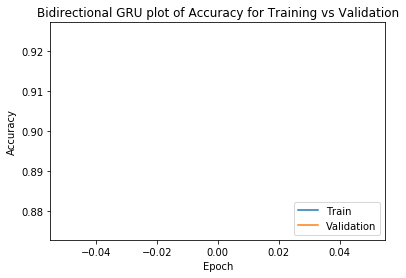

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [46]:
plot6=accuracy_plot("Bidirectional GRU plot of Accuracy for Training vs Validation", Bidirectional_GRU_history)
plot6

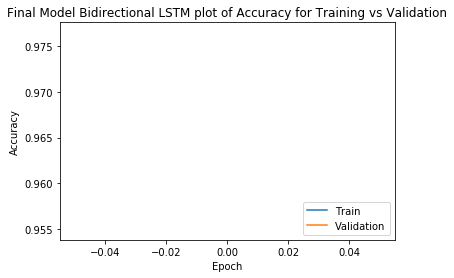

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [47]:
final_model_plot7=accuracy_plot("Final Model Bidirectional LSTM plot of Accuracy for Training vs Validation", Final_model_Bidirectional_LSTM_history)
final_model_plot7

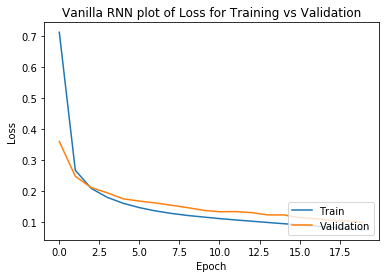

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [48]:
plot1=loss_plot("Vanilla RNN plot of Loss for Training vs Validation", vanilla_RNN_history)
plot1

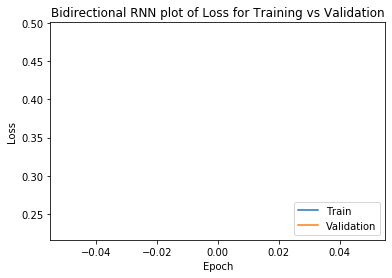

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [49]:
plot2=loss_plot("Bidirectional RNN plot of Loss for Training vs Validation", Bidirectional_RNN_history)
plot2

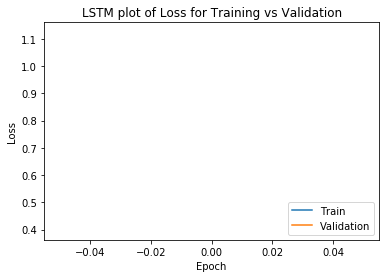

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [50]:
plot3=loss_plot("LSTM plot of Loss for Training vs Validation", LSTM_history)
plot3

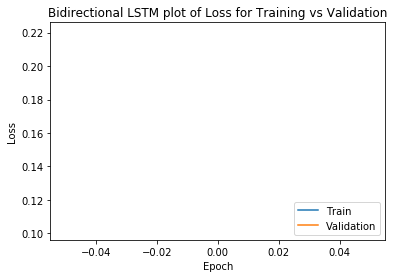

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [51]:
plot4=loss_plot("Bidirectional LSTM plot of Loss for Training vs Validation", Bidirectional_LSTM_history)
plot4

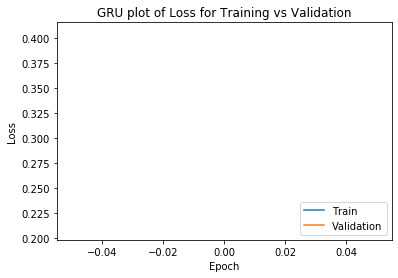

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [52]:
plot5=loss_plot("GRU plot of Loss for Training vs Validation", GRU_history)
plot5

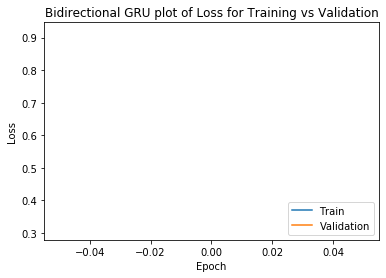

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [53]:
plot6=loss_plot("Bidirectional GRU plot of Loss for Training vs Validation", Bidirectional_GRU_history)
plot6

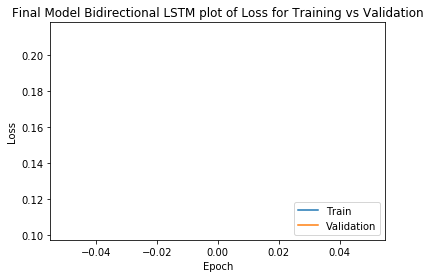

<module 'matplotlib.pyplot' from 'C:\\Users\\jayma\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [54]:
final_model_plot7=loss_plot("Final Model Bidirectional LSTM plot of Loss for Training vs Validation", Final_model_Bidirectional_LSTM_history)
final_model_plot7